<a href="https://colab.research.google.com/github/ian-byrne/MADSmilestone2/blob/main/Labeling/Cleaning_labeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring, Cleaning and Labeling the data
### Stacey Beck and Ian Byrne

<br><br/>

##### **AI Crowd Labeling Method**

We received inspiration from the AI Crowd's Alzheimer's Clock Challenge and reached out to their data team inquiring about labeling the clock images for that challenge. Ankit < insert last name > explained that they use the values in the variable 'hc1disescn9' to help label the images. The variable 'hc1disescn9' contains values that indicate whether someone has dementia/Alzheimer's or not. A response of '1 YES' indicates that they have a confirmed diagnosis of Alzheimer's or Dementia and '2 NO' indicates no diagnosis has been given. A value of '7' indicates that a response of '1 YES' has already been recorded in a previous round. AI Crowd labeled each image as either:
  - 0 - Pre-Alzheimers
  - 1 - Post-Alzheimers 
  - 2 - Normal

If a subject reports '1 YES' in the variable 'hc1disescn9' in a later round, all the previous rounds receive the label '0 - Pre-Alzheimers'. All 'hc1disescn9' reports of '1 YES' and '7' receive the label '1 - Post-Alzheimers' for the current and subsequent rounds.  All else receive the label '2 - Normal.' 

We provide code to produce labels using this algorithm. 

 
<br><br/>
 
##### **NHATs Study Criteria used to help make Labels**

In addition, we also feel that this way of labeling can lead to false negatives in terms of whether someone might have dementia/Alzheimer's disease. There may be participants whose diagnosis has gone undetected by medical professionals and who are able to complete the NHATs survey, thus leading to a label of '2 - Normal' for their drawings. 

In order to provide a potentially more robust set of label parameters, we will also implement a label strategy that mimicks the NHAT study found in this report. https://www.nhats.org/sites/default/files/inline-files/DementiaTechnicalPaperJuly_2_4_2013_10_23_15.pdf (page 2)


We will use these specific labels to identify if someone has:
- 0 - 'Possible Dementia'
- 1 - 'Probable Dementia' (Likely Dementia)
- 2 - 'No Dementia' 

**Variables used to help classify '0' for "Possible Dementia":**
- One cognitive test score with cut off <= 1.5 SD below the mean. 

**Variables used to help classify '1' for 'Probable Dementia' include:**
-  'hc1disescn9' for diagnosis ('1 YES', '2 NO', '7') and if this is not provided we will look at:
  - 'cp1dad8dem' which provides a diagnosing like score through the use of a proxy. 
- Two cognitive test scores with cut offs <= 1.5 SD below the mean. 


**All else will be labeled as '2' for 'No Dementia."**

<br><br/>
The cognitive tests are based in three domains:
- ***Orientation*** 
    - President and VP First and Last names: **'cg1presidna1', 'cg1presidna3', 'cg1vpname1', 'cg1vpname3'**
    - Date, Month, Year, Day of the Week: **'cg1todaydat1' (Month), 'cg1todaydat2' (Day), 'cg1todaydat3' (Year), 'cg1todaydat4' (Day of the Week)**
    - Each correct answer gets a point; Total points out of 8.
    - Score cut point for <= 1.5 SD below the mean is <= 3 across all variables
- ***Memory*** 
    - Delayed Word Recall: **'cg1dwrdimmrc' (total Score)**
    - Immediate Word Recall: **'cg1dwrddlyrc' (total Score)** 
    - Total points out of 20
    - Score cut off is <= 3 across all variables
- ***Executive Functioning*** 
    - Clock Drawing Battery: **'cg1dclkdraw'**
    - Total points out of 5
    - Score cut off is <= 1 


***Each variable is used for all 9 years of this study and change only by the number value located within the variable name.***


In [1]:
# Clone the entire repo.
!git clone -l -s https://github.com/ian-byrne/MADSmilestone2.git

# Change directory into cloned repo
%cd MADSmilestone2

# List repo contents
!ls

Cloning into 'MADSmilestone2'...
remote: Enumerating objects: 257, done.
remote: Counting objects: 100% (257/257), done.
remote: Compressing objects: 100% (214/214), done.
remote: Total 257 (delta 129), reused 102 (delta 37), pack-reused 0
Receiving objects: 100% (257/257), 1.76 MiB | 5.01 MiB/s, done.
Resolving deltas: 100% (129/129), done.
/content/MADSmilestone2
ian_testingground.ipynb  Images.py  Loading    Supervised_CNN.ipynb
Images.ipynb		 Labeling   README.md


In [16]:
#!rm -rf /content/MADSmilestone2

### AI Crowd Labeling Strategy

---



In [2]:
import pandas as pd
import numpy as np
import Labeling.clean_rounds as cr
import Labeling.label_data as ld
import matplotlib.pyplot as plt



# Load Rounds data
rounds = pd.read_csv('Loading/round_data.csv')
rounds

,spid,cg1dclkdraw,hc1disescn9,round
0,10000003.0,3 Mildly distorted depiction of a clock,2 NO,1
1,10000004.0,3 Mildly distorted depiction of a clock,2 NO,1
2,10000005.0,3 Mildly distorted depiction of a clock,2 NO,1
3,10000006.0,4 Reasonably accurate depiction of a clock,2 NO,1
4,10000007.0,-2 Proxy says cannot ask SP,2 NO,1
...,...,...,...,...
62686,20007109.0,4 Reasonably accurate depiction of a clock,7 PREVIOUSLY REPORTED,10
62687,20007110.0,5 Accurate depiction of a clock (circular or s...,2 NO,10
62688,20007111.0,5 Accurate depiction of a clock (circular or s...,2 NO,10
62689,20007112.0,5 Accurate depiction of a clock (circular or s...,2 NO,10


###Check values for columns of interest
- we used the user guide to determine which columns are required


In [3]:
print("Column values for clock scores: \n", rounds['cg1dclkdraw'].unique())
print("\nHealth score values: \n", rounds['hc1disescn9'].unique())
print("\nVariable types: \n", rounds.dtypes)
rounds[rounds['cg1dclkdraw'] == '-1 Inapplicable'].head()

Column values for clock scores: 
 ['3 Mildly distorted depiction of a clock'
 '4 Reasonably accurate depiction of a clock'
 '-2 Proxy says cannot ask SP'
 '2 Moderately distorted depection of a clock' '-1 Inapplicable'
 '-7 SP refused to draw clock'
 '5 Accurate depiction of a clock (circular or square)'
 '1 Severely distorted depiction of a clock'
 '-4 SP did not attempt to draw clock' '0 Not recognizable as a clock'
 '-3 Proxy says can ask SP but SP unable to answer' '-9 Missing'
 '2 Moderately distorted depiction of a clock']

Health score values: 
 [' 2 NO' '-1 Inapplicable' ' 1 YES' '-9 Missing' '-8 DK' '2 NO'
 '7 PREVIOUSLY REPORTED' '1 YES' '-7 RF']

Variable types: 
 spid           float64
cg1dclkdraw     object
hc1disescn9     object
round            int64
dtype: object


,spid,cg1dclkdraw,hc1disescn9,round
6,10000009.0,-1 Inapplicable,-1 Inapplicable,1
8,10000013.0,-1 Inapplicable,-1 Inapplicable,1
10,10000015.0,-1 Inapplicable,-1 Inapplicable,1
33,10000046.0,-1 Inapplicable,-9 Missing,1
47,10000067.0,-1 Inapplicable,-9 Missing,1


In [4]:
# Load the cleaned dataframe
cleaned_rounds = cr.clean_data(rounds)
cleaned_rounds

,spid,cg1dclkdraw,hc1disescn9,round
0,10000003,3 Mildly distorted depiction of a clock,2.0,1
1,10000004,3 Mildly distorted depiction of a clock,2.0,1
2,10000005,3 Mildly distorted depiction of a clock,2.0,1
3,10000006,4 Reasonably accurate depiction of a clock,2.0,1
5,10000008,2 Moderately distorted depection of a clock,2.0,1
...,...,...,...,...
62686,20007109,4 Reasonably accurate depiction of a clock,7.0,10
62687,20007110,5 Accurate depiction of a clock (circular or s...,2.0,10
62688,20007111,5 Accurate depiction of a clock (circular or s...,2.0,10
62689,20007112,5 Accurate depiction of a clock (circular or s...,2.0,10


In [5]:
#Check that we only have healthscores of 1, 2, 7 and subjects that have drawn clocks
print("health score check: \n",cleaned_rounds.cg1dclkdraw.unique())
print("\n clock scores check: \n",cleaned_rounds['hc1disescn9'].unique())

health score check: 
 ['3 Mildly distorted depiction of a clock'
 '4 Reasonably accurate depiction of a clock'
 '2 Moderately distorted depection of a clock'
 '5 Accurate depiction of a clock (circular or square)'
 '1 Severely distorted depiction of a clock'
 '0 Not recognizable as a clock'
 '2 Moderately distorted depiction of a clock']

 clock scores check: 
 [2. 1. 7.]


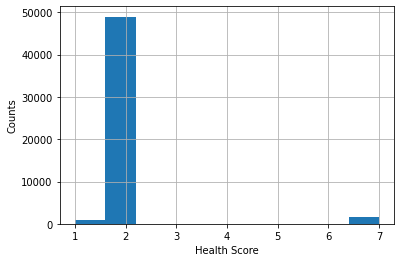

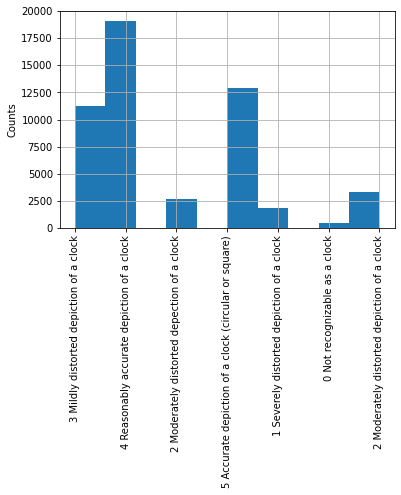

In [6]:
# Check balance of dataset
a = cleaned_rounds.hc1disescn9.hist() 
plt.xlabel("Health Score")
plt.ylabel("Counts")
plt.show(a) 


b = cleaned_rounds.cg1dclkdraw.hist()
b.tick_params(axis='x', labelrotation = 90)
plt.ylabel("Counts")
plt.show(b)

###Create Labels for the rounds data

In [7]:
labeled_data = ld.create_labels(cleaned_rounds)
labeled_data

,spid,cg1dclkdraw,hc1disescn9,round,label
0,10000003,3 Mildly distorted depiction of a clock,2.0,1,2
1,10000004,3 Mildly distorted depiction of a clock,2.0,1,2
2,10000005,3 Mildly distorted depiction of a clock,2.0,1,2
3,10000006,4 Reasonably accurate depiction of a clock,2.0,1,2
5,10000008,2 Moderately distorted depection of a clock,2.0,1,2
...,...,...,...,...,...
62686,20007109,4 Reasonably accurate depiction of a clock,7.0,10,1
62687,20007110,5 Accurate depiction of a clock (circular or s...,2.0,10,2
62688,20007111,5 Accurate depiction of a clock (circular or s...,2.0,10,2
62689,20007112,5 Accurate depiction of a clock (circular or s...,2.0,10,2


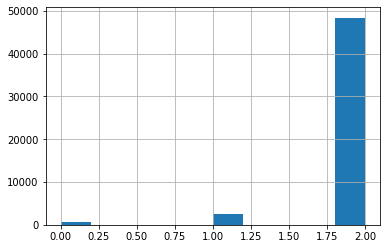

In [8]:
# Look at distribution of labels
labeled_data.label.hist() 

In [9]:
labeled_data['label'].value_counts()

2    48371
1     2533
0      588
Name: label, dtype: int64

### NHATs Strategy for Labeling Data

---



In [13]:
round_hat_data = pd.read_csv('Loading/hats_round_data.csv')
round_hat_data.head()

In [ ]:
# Check all values for each variable prior to cleaning; variables are picked from
# NHATs User Guide
columns_to_keep = ['cg1presidna1','cg1presidna3','cg1vpname1','cg1vpname3',
           'cg1todaydat1','cg1todaydat2','cg1todaydat3', 'cg1todaydat4',
           'cg1dclkdraw','hc1disescn9', 'cp1dad8dem', 'cg1dwrdimmrc',
           'cg1dwrddlyrc']

d = round_hat_data[columns_to_keep]

for col in d.columns:
  print("\n{}: \n".format(col), d[col].unique())
  for item in d[col].unique():
    print("\n", item)

In [ ]:
# Run cleaning script resave dataframe
round_hat_clean = cr.clean_hats_rounds(round_hat_data)

In [ ]:
# Check all column values again
columns_to_keep = ['cg1presidna1','cg1presidna3','cg1vpname1','cg1vpname3',
           'cg1todaydat1','cg1todaydat2','cg1todaydat3', 'cg1todaydat4',
           'cg1dclkdraw','hc1disescn9', 'cp1dad8dem', 'cg1dwrdimmrc',
           'cg1dwrddlyrc']

d = round_hat_clean[columns_to_keep]

for col in d.columns:
  print("\n{}: \n".format(col), d[col].unique())
  for item in d[col].unique():
    print("\n", item)

In [ ]:
# Drop the rest of the NaN values since we do not have data for these subjects and
# cannot conclude their scores
round_hat_clean.dropna(inplace=True)

# Check dtypes
round_hat_clean.dtypes

In [ ]:
# Change variable value types from Categorical to Int64 for later calculations
col_to_change = ['cg1presidna1','cg1presidna3','cg1vpname1','cg1vpname3',
           'cg1todaydat1','cg1todaydat2','cg1todaydat3', 'cg1todaydat4',
           'cg1dclkdraw','hc1disescn9', 'cp1dad8dem', 'cg1dwrdimmrc',
           'cg1dwrddlyrc']
round_hat_clean[col_to_change] = round_hat_clean[col_to_change].apply(pd.to_numeric)
round_hat_clean.dtypes

In [ ]:
# Create orientation and memory scores
round_hat_clean['orientation_score'] = round_hat_clean['cg1presidna1'] + round_hat_clean['cg1presidna3'] \
+ round_hat_clean['cg1vpname1'] + round_hat_clean['cg1vpname3'] + round_hat_clean['cg1todaydat1']\
+ round_hat_clean['cg1todaydat2'] + round_hat_clean['cg1todaydat3'] + round_hat_clean['cg1todaydat4']

round_hat_clean['memory_score'] = round_hat_clean['cg1dwrdimmrc'] + round_hat_clean['cg1dwrddlyrc']
round_hat_clean.head()

,spid,cg1dclkdraw,hc1disescn9,cg1presidna1,cg1presidna3,cg1vpname1,cg1vpname3,cg1todaydat1,cg1todaydat2,cg1todaydat3,cg1todaydat4,cg1dwrdimmrc,cg1dwrddlyrc,round,cp1dad8dem,orientation_score,memory_score
0,10000003,3.0,2,1,1,1,1,1.0,1.0,1.0,1.0,6.0,3.0,1,10,8.0,9.0
1,10000004,3.0,2,1,1,0,0,1.0,1.0,1.0,1.0,4.0,3.0,1,10,6.0,7.0
2,10000005,3.0,2,1,1,1,1,1.0,1.0,1.0,1.0,7.0,4.0,1,10,8.0,11.0
3,10000006,4.0,2,1,1,1,0,1.0,1.0,1.0,1.0,4.0,3.0,1,10,7.0,7.0
5,10000008,2.0,2,1,1,1,1,1.0,1.0,1.0,1.0,7.0,7.0,1,10,8.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4383,20007107,5.0,2,1,1,1,1,1.0,1.0,1.0,1.0,4.0,4.0,10,0,8.0,8.0
4384,20007109,4.0,7,1,1,1,0,1.0,1.0,1.0,1.0,6.0,4.0,10,0,7.0,10.0
4385,20007110,5.0,2,1,1,1,1,1.0,0.0,1.0,0.0,4.0,3.0,10,0,6.0,7.0
4386,20007111,5.0,2,0,0,1,1,1.0,1.0,1.0,1.0,8.0,8.0,10,0,6.0,16.0


In [ ]:
# Call script that creates the labels for each subject
round_hat_label = ld.create_hats_labels(round_hat_clean)
round_hat_label.sample(10)

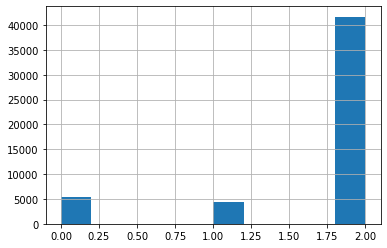

In [ ]:
round_hat_label.label.hist() 

In [ ]:
final_data = round_hat_label[['round', 'spid', 'label']]
final_data.sample(10)

,round,spid,label
0,1,10000003,2
1,1,10000004,2
2,1,10000005,2
3,1,10000006,2
5,1,10000008,2
...,...,...,...
4383,10,20007107,2
4384,10,20007109,1
4385,10,20007110,2
4386,10,20007111,2


In [ ]:
final_data['label'].value_counts()

2    41656
0     5312
1     4393
Name: label, dtype: int64

### Get Individual participant IDs and labels per round
- useful for pulling in exact images per round
- create text file to store dictionary

- create one dictionary file for AI Crowd method of labeling
- create one dictionary file for NHAT Study Dementia Labeling method

In [ ]:
# get round, id, label for AI crowd method
ids_ai = ld.get_ids(labeled_data)

# get round, id, label for NHAT method
ids_hats = ld.get_ids(final_data)

In [11]:
# Writing dictionary to text file for AI Crowd method of labeling
try:
    id_file = open('roundIdLabelDict.txt', 'wt')
    id_file.write(str(ids_ai))
    id_file.close()
  
except:
    print("Unable to write to file")

In [ ]:
# Writing dictionary to text file for NHATs method of labeling
try:
    id_file = open('hatRoundIdLabelDict.txt', 'wt')
    id_file.write(str(ids_hats))
    id_file.close()
  
except:
    print("Unable to write to file")